In [1]:
import random

import numpy as np

from matplotlib import pyplot as plt

from snn.graphs import plot_network
from snn.spiking_network import SpikingNetwork

from snn.layers import SCTNLayer
from snn.spiking_neuron import create_SCTN, IDENTITY

## Linear output

In [2]:
clk_freq = 1536000

network = SpikingNetwork(clk_freq)

neuron = create_SCTN()
neuron.theta = -200
neuron.activation_function = IDENTITY
neuron.membrane_should_reset = False
network.add_layer(SCTNLayer([neuron]))
network.log_out_spikes(-1)

test_size = 100000
x1 = np.ones(test_size) * 50
network.input_full_data(x1)

spikes = network.neurons[-1].out_spikes(False, test_size)

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


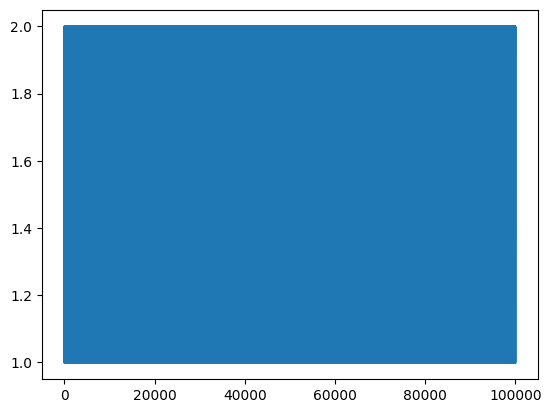

In [3]:
# cspikes = spikes.cumsum()
cspikes = np.convolve(spikes, np.ones(3, dtype=int), 'valid')

plt.plot(np.linspace(0, test_size, len(cspikes)), cspikes)

## Max output Neuron

In [4]:
def generate_w(size, prob):
    return (np.random.random(size) < prob).astype(int)


def multiple_w0(cycles, w_size):
    return np.concatenate([generate_w(w_size, ((np.sin(i)*75) + 250)/325) for i in np.linspace(0, cycles*2*np.pi, int(cycles*2*np.pi*w_size))])


def multiple_w1(cycles, w_size):
    return np.concatenate([generate_w(w_size, (((-np.sin(i))*75) + 250)/325) for i in np.linspace(0, cycles*2*np.pi, int(cycles*2*np.pi*w_size))])

W = 300
spikes_input = np.stack([multiple_w0(4, W), multiple_w1(4, W)]).T
print(spikes_input[:, 0].sum(), spikes_input[:, 1].sum())

1739591 1740370


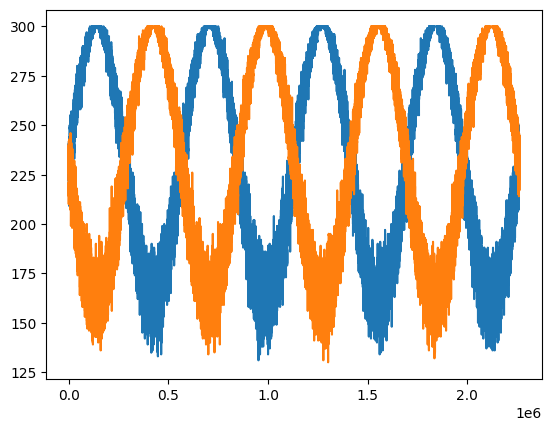

In [5]:
y0 = np.convolve(spikes_input[:, 0], np.ones(W, dtype=int), 'valid')
y1 = np.convolve(spikes_input[:, 1], np.ones(W, dtype=int), 'valid')
plt.plot(y0)
plt.plot(y1)

In [6]:
from snn.spiking_neuron import BINARY

clk_freq = 1536000

network = SpikingNetwork(clk_freq)

neuron = create_SCTN()
neuron.theta = -.1
neuron.synapses_weights = np.array([5, 5], dtype=np.float64)
neuron.leakage_factor = 5
neuron.leakage_period = 72
neuron.threshold_pulse = 300
neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
neuron.activation_function = BINARY

time_to_learn = 2.5e-3
A_LTP = .00025
A_LTD = -.00015
tau = network.clk_freq * time_to_learn / 2
neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, 100, 0)

network.add_layer(SCTNLayer([neuron]))
network.log_out_spikes(-1)
network.log_membrane_potential(-1)

In [7]:

weights = [0] * len(spikes_input)
for i, spikes in enumerate(spikes_input):
    network.input(spikes)
    weights[i] = neuron.synapses_weights
weights = np.array(weights)

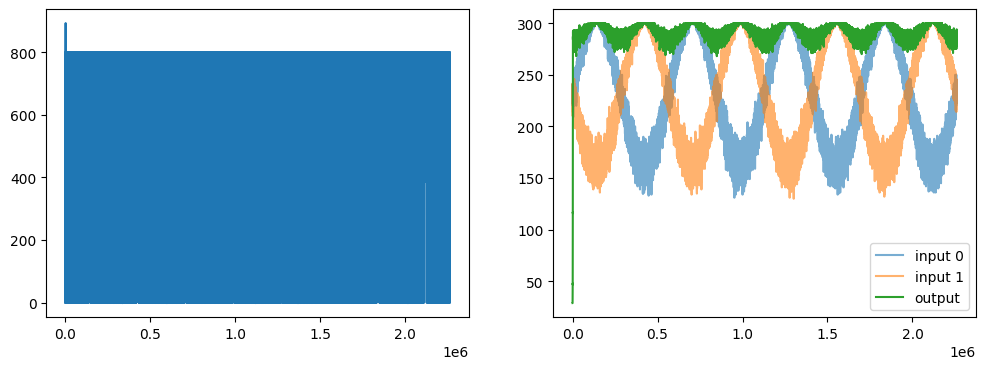

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(neuron.membrane_potential_graph())

y_output = np.convolve(neuron.out_spikes(False, len(spikes_input)), np.ones(W, dtype=int), 'valid')
axs[1].plot(y0, label='input 0', alpha=.6)
axs[1].plot(y1, label='input 1', alpha=.6)
axs[1].plot(y_output, label='output', alpha=1)
axs[1].legend()

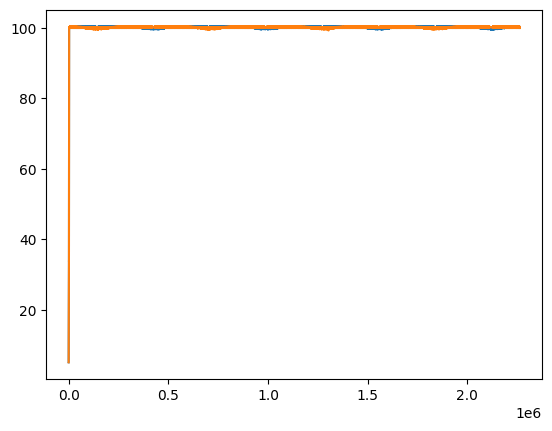

In [9]:
plt.plot(weights[:, 0])
plt.plot(weights[:, 1])

## Resonator with maximum and phase shifting

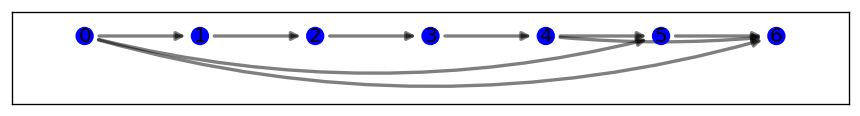

In [10]:
from snn.resonator import lp_by_lf, freq_of_resonator


def create_custom_resonator(freq0, clk_freq, lf, weight, theta):
    lp = lp_by_lf(lf, freq0, clk_freq)

    network = SpikingNetwork(clk_freq)
    network.add_amplitude(10000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    for i in range(4):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weight], dtype=np.float64)
        neuron.leakage_factor = lf
        neuron.leakage_period = lp
        neuron.theta = theta
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # min neuron
    neuron = create_SCTN()
    neuron.theta = -.1
    neuron.synapses_weights = np.array([15, 15], dtype=np.float64)
    neuron.leakage_factor = 5
    neuron.leakage_period = 72
    neuron.threshold_pulse = 300
    neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    neuron.activation_function = BINARY
    time_to_learn = 2.5e-5
    A_LTP = .0025
    A_LTD = -.0015
    tau = network.clk_freq * time_to_learn / 2
    neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, 75, 0)
    network.add_layer(SCTNLayer([neuron]))
    network.connect_by_id(0, 5)

    # x1 + x2 - 2min(x1, x2)
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([-2, 1, 1], dtype=np.float64)
    neuron.leakage_factor = lf
    neuron.leakage_period = lp
    neuron.threshold_pulse = 2
    neuron.theta = -.1
    neuron.activation_function = BINARY
    network.add_layer(SCTNLayer([neuron]))

    network.connect_by_id(0, 6)
    network.connect_by_id(4, 6)
    return network

resonator = create_custom_resonator(104, 1536000, 5, 10, -5)
plot_network(resonator)

In [11]:
def generate_and_input_signal(resonator, duration, f):
    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * f
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

def neuron_output(neuron, rolling_window, duration, signal_freq, shift_degrees=0, cycles=5):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > (duration - ((8+cycles)/signal_freq)) * clk_freq + shift_samples) &
        (y_events < (duration - (8/signal_freq)) * clk_freq + shift_samples)
    ]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    y_spikes = np.zeros(int(cycles/signal_freq * clk_freq) + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(rolling_window, dtype=int), 'valid')
    return y_spikes_rollsum

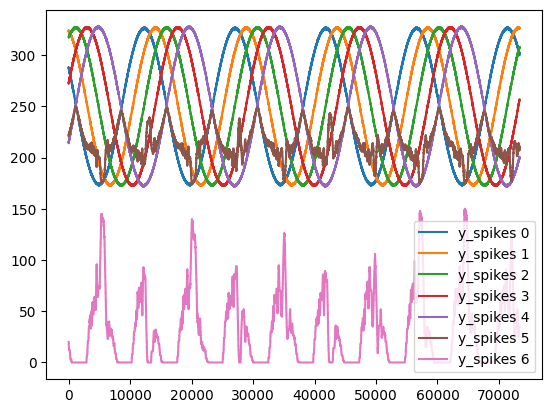

In [12]:
freq0 = 104
resonator = create_custom_resonator(freq0, 1536000, 5, 10, -5)
duration = .6
spikes_window_size = 500

for i in range(7):
    resonator.log_out_spikes(i)

generate_and_input_signal(resonator, duration, freq0)
for i in range(7):
# for i in [0, 4]:
    try:
        y_spikes = neuron_output(resonator.neurons[i], spikes_window_size, duration, freq0)
    except ValueError:
        print(f'neuron {i} didnt emit spikes')
        continue
    plt.plot(y_spikes, label=f'y_spikes {i}')
plt.legend()

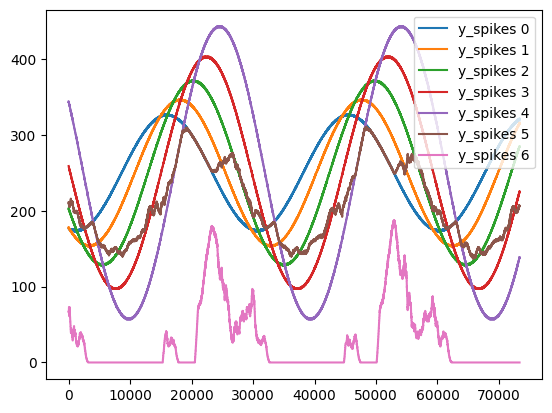

In [13]:
freq0 = 104
resonator = create_custom_resonator(freq0, 1536000, 5, 10, -5)
duration = .6
spikes_window_size = 500

for i in range(7):
    resonator.log_out_spikes(i)

generate_and_input_signal(resonator, duration, freq0/2)
for i in range(7):
# for i in [0, 4]:
    try:
        y_spikes = neuron_output(resonator.neurons[i], spikes_window_size, duration, freq0)
    except ValueError:
        print(f'neuron {i} didnt emit spikes')
        continue
    plt.plot(y_spikes, label=f'y_spikes {i}')
plt.legend()

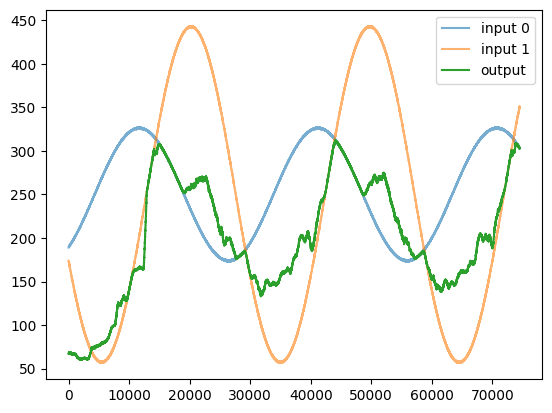

In [14]:
from snn.spiking_neuron import BINARY

clk_freq = 1536000
duration = .6

s_ts = resonator.neurons[0].out_spikes()
s0 = np.zeros(int(clk_freq * duration))
s0[s_ts] = 1
s0 = s0[25000:100000]

s_ts = resonator.neurons[4].out_spikes()
s4 = np.zeros(int(clk_freq * duration))
s4[s_ts] = 1
s4 = s4[25000:100000]

y0 = np.convolve(s0, np.ones(spikes_window_size, dtype=int), 'valid')
y1 = np.convolve(s4, np.ones(spikes_window_size, dtype=int), 'valid')
plt.plot(y0, label='input 0', alpha=.6)
plt.plot(y1, label='input 1', alpha=.6)

spikes_input = np.stack([s0, s4]).T
network = SpikingNetwork(clk_freq)

neuron = create_SCTN()
neuron.theta = -.1
neuron.synapses_weights = np.array([15, 15], dtype=np.float64)
neuron.leakage_factor = 5
neuron.leakage_period = 72
neuron.threshold_pulse = 300
neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
neuron.activation_function = BINARY
time_to_learn = 2.5e-5
A_LTP = .0025
A_LTD = -.0015
tau = network.clk_freq * time_to_learn / 2
neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, 75, 0)

network.add_layer(SCTNLayer([neuron]))
network.log_out_spikes(-1)

weights = [0] * len(spikes_input)
for i, spikes in enumerate(spikes_input):
    network.input(spikes)
    weights[i] = neuron.synapses_weights
weights = np.array(weights)

y_output = np.convolve(neuron.out_spikes(False, len(s0)), np.ones(spikes_window_size, dtype=int), 'valid')
plt.plot(y_output, label='output', alpha=1)
plt.legend()

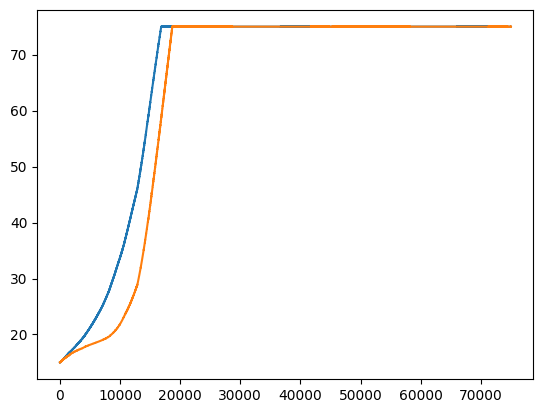

In [15]:
plt.plot(weights[:, 0])
plt.plot(weights[:, 1])

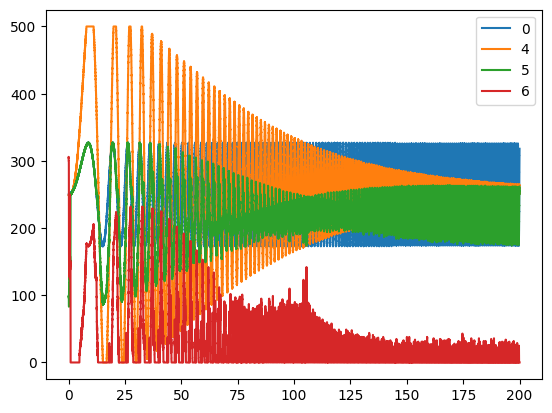

In [16]:
from snn.resonator import test_resonator_on_chirp

start_freq = 0
spectrum = 200
spikes_window_size = 500
# best_params = base_params

resonator = create_custom_resonator(104, 1536000, 5, 10, -5)
for i in range(7):
    resonator.log_out_spikes(i)

step = 1 / 10000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

for i in [0, 4, 5, 6]:
    spikes_neuron = resonator.neurons[i]
    y_spikes = spikes_neuron.out_spikes(False, test_size)
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
    # print(f'peak: {x[1000+np.argmax(y_spikes[1000:])]}')

    # best_lp = lp_by_lf(lf, freq0, clk_freq)
    # f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
    # plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f} peak: {x[1000+np.argmax(y_spikes[1000:])]}')
    plt.plot(x, y_spikes, label=f'{i}')
plt.legend()הבעיה

# Resonator by stdp

In [228]:
def stdp_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
        A_LTP,
        A_LTD,
        time_to_learn,
        max_weight,
        min_weight,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    tau = network.clk_freq * time_to_learn / 2

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, max_weight, min_weight)
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        # neuron.set_stdp(A_LTP, A_LTD, tau, clk_freq, max_weight, min_weight)
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

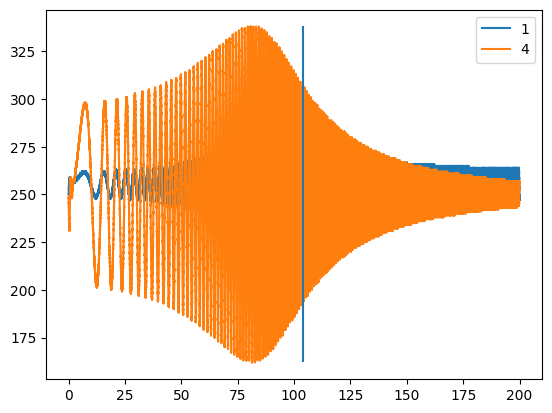

In [349]:
%matplotlib inline
from snn.resonator import test_resonator_on_chirp

start_freq = 0
spectrum = 200
spikes_window_size = 500
freq0 = 104
resonator = stdp_resonator(freq0, 1536000, 5,
                           thetas=[-6.8, -7.0, -6.6, -7.7],
                           # weights=[10.057, 7.943, 10.16, 10.245, 10.18],# 104
                           # weights=[10.047, 7.27, 12.862, 12.992, 12.732], # 118
                           weights=[15.25, 1.5, 14.0, 12.75, 15.25],
                           A_LTP=0.0, A_LTD=0.0,
                           time_to_learn=2.5e-5,
                           max_weight=50, min_weight=-50)
log_spikes = [1, 4]
for i in log_spikes:
    resonator.log_out_spikes(i)

step = 100 / 1536000
test_size = int(spectrum / step)
test_resonator_on_chirp(resonator, start_freq=start_freq, step=step, test_size=test_size, clk_freq=clk_freq)

min_graph = np.inf
max_graph = 0
for i in log_spikes:
    spikes_neuron = resonator.neurons[i]
    y_spikes = spikes_neuron.out_spikes(False, test_size)
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    min_graph = np.min([y_spikes.min(), min_graph])
    max_graph = np.max([y_spikes.max(), max_graph])
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
    plt.plot(x, y_spikes, label=f'{i}')
plt.vlines(freq0, min_graph, max_graph)
plt.legend()

In [343]:
from snn.resonator import create_chirp_signal

shift = 0
spikes_window_size = 500

def flat_weights():
    ws = []
    for i in range(1, 5):
        neuron = resonator.neurons[i]
        for w in neuron.synapses_weights:
            ws.append(abs(float(f'{w:.3f}')))
    return ws

def flat_thetas():
    return [float(f'{neuron.theta:.3f}') for neuron in resonator.neurons[1:5]]

step = 100 / 1536000
test_size = int(spectrum / step)

resonator = stdp_resonator(freq0, 1536000, 5,
                           thetas=[-1.3, -6.5, -6.5, -6.5],
                           weights=[7, 5.5, 5, 5, 5],
                           # weights=[11, 9, 10, 10, 10],
                           A_LTP=0, A_LTD=0,
                           time_to_learn=2.5e-4,
                           max_weight=50, min_weight=-50)
log_spikes = range(1, 5)
for i in log_spikes:
    resonator.neurons[i].stdp = None
    resonator.log_out_spikes(i)

[7.0, 5.5, 5.0, 5.0, 5.0]
[8.16, 4.595, 7.405, 7.16, 7.305] 0 0 3071
[8.7, 3.99, 8.59, 8.5, 8.87] 1 1152 1843
[8.81, 3.885, 8.455, 8.625, 9.14] 3 1756 1229
[8.745, 3.91, 8.665, 8.78, 9.29] 5 1759 1225
[8.815, 3.845, 8.85, 8.995, 9.6] 7 1694 1272
[8.915, 3.935, 9.06, 9.07, 9.66] 9 1758 1250
[9.02, 3.89, 9.15, 9.18, 9.75] 11 1807 1196
[8.93, 3.865, 9.145, 9.075, 9.81] 13 1885 1126
[8.995, 3.775, 8.995, 9.265, 9.9] 15 1842 1176
[8.975, 3.75, 9.085, 9.34, 9.935] 17 1814 1192
[8.95, 3.775, 9.225, 9.235, 10.02] 19 1844 1175
[8.93, 3.685, 9.25, 9.39, 10.1] 21 1842 1181
[8.865, 3.6, 9.13, 9.205, 10.05] 23 1899 1123
[8.825, 3.47, 9.065, 9.19, 10.03] 25 1877 1149
[8.825, 3.605, 9.1, 8.985, 10.05] 27 1899 1126
[8.825, 3.555, 8.925, 9.115, 10.08] 29 1867 1166
[8.775, 3.595, 8.905, 9.08, 10.12] 31 1856 1172
[8.835, 3.455, 8.855, 9.055, 9.875] 33 1889 1136
[8.735, 3.425, 8.625, 8.96, 9.84] 35 1910 1096
[8.845, 3.375, 8.35, 8.765, 9.765] 37 1869 1080
[8.75, 3.395, 8.3, 8.565, 9.765] 0 1876 1086
[8.81

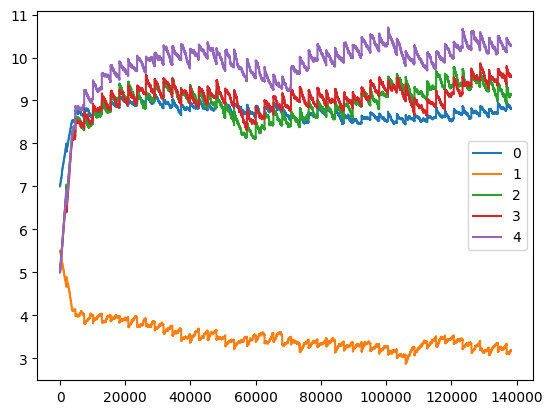

In [275]:
from random import random
epochs = 50
weights_progress = []
thetas_progress = []

a_ltp = 0.005
a_ltd = -0.005
theta_bias = 0.0001
print(flat_weights())
for x in range(epochs):
    start_freq = (x*2) % 40
    test_size = int(spectrum / step)
    counts_potentiation = 0
    counts_depression = 0
    while test_size > 0:
        sine_size = min(spikes_window_size, test_size)
        sine_wave, freqs = create_chirp_signal(sine_size, clk_freq, start_freq, step, shift)
        resonator.input_full_data(sine_wave)
        neuron = resonator.neurons[4]
        spikes = len(neuron.out_spikes())
        i = rnd.randint(1, 4)
        neuron = resonator.neurons[i]

        # in cut-off frequency
        if  -5 < start_freq - freq0 < 5:
            if spikes < 250:
                counts_potentiation  += 1
                if i == 1 and random() < .5:
                    neuron.synapses_weights[1] += a_ltd
                else:
                    neuron.synapses_weights[0] += a_ltd
            else:
                counts_depression += 1
                if i == 1 and random() < .5:
                    neuron.synapses_weights[1] += a_ltp
                else:
                    neuron.synapses_weights[0] += a_ltp
        else:
            if spikes < 250:
                counts_potentiation  += 1
                if random() < .75:
                    if i == 1 and random() < .5:
                        neuron.synapses_weights[1] += a_ltp
                    else:
                        neuron.synapses_weights[0] += a_ltp
                else:
                    neuron.theta += theta_bias
            if spikes > 280:
                counts_depression += 1
                if random() < .75:
                    if i == 1 and random() < .5:
                        neuron.synapses_weights[1] += a_ltd
                    else:
                        neuron.synapses_weights[0] += a_ltd
                else:
                    neuron.theta -= theta_bias
            weights_progress.append(flat_weights())
            thetas_progress.append(flat_thetas())
            neuron.forget_logs()
        shift = freqs[-1]
        start_freq += sine_size * step
        test_size -= sine_size
    print(flat_weights(), int(start_freq-100), counts_depression, counts_potentiation)

weights_progress = np.array(weights_progress).T
for i in range(5):
    plt.plot(weights_progress[i], label=f'{i}')
plt.legend()

In [272]:
flat_weights(), flat_thetas()

([9.835, 6.155, 11.734, 12.64, 11.014], [-1.565, -6.738, -6.756, -6.747])

### Phase optimization

In [292]:
def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    tau = network.clk_freq * time_to_learn / 2

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

In [344]:
import random as rnd
from tqdm.notebook import tqdm

freq0 = 104
duration = .5
resonator = simple_resonator(freq0, thetas=[-2] * 4, weights=[6] * 5, lf=5, clk_freq=clk_freq)
# resonator = simple_resonator(freq0, thetas=[-1, -5, -5, -5], weights=[11, 9, 10, 10, 10], lf=5, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)

def min_max_mean_on_sin(resonator, f, return_output=False):
    generate_and_input_signal(resonator, duration, f)

    mins, maxs, means = [], [], []
    for i in range(1, len(resonator.neurons)):
        try:
            output = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        except ValueError:
            mins.append(0)
            maxs.append(0)
            means.append(0)

        mins.append(output.min())
        maxs.append(output.max())
        means.append(int(output.mean()))

    resonator.forget_logs()
    if return_output:
        return np.array([mins, maxs, means]), output
    return np.array([mins, maxs, means])

a_ltp = 0.25
a_ltd = -0.25
theta_bias = 0.5
# for epoch in range(epochs):
epoch = 0

fig, ax = plt.subplots(figsize=(12, 3))
lineplot, = ax.plot([0, 501]* (73348//2))
with tqdm() as pbar:
    while True:
        pbar.set_description(f'epoch {epoch}')
        epoch += 1
        # choose randomly if i should use the base freq or different freqs
        chosen_freq_index = rnd.randint(0, 3)

        base_stats, output = min_max_mean_on_sin(resonator, freq0, return_output=True)
        lower_stats = min_max_mean_on_sin(resonator, freq0/3)
        higher_stats = min_max_mean_on_sin(resonator, freq0*2)

        lineplot.set_xdata(np.arange(len(output)))
        lineplot.set_ydata(output)
        ax.set_xlim(0, len(output))
        ax.set_ylim(output.min()-2, output.max()+2)
        fig.canvas.draw()
        fig.canvas.flush_events()

        # first check dc.
        # if the dc is not at the middle of the `spikes_window_size` dc should be toward that.
        means_base = base_stats[2]
        should_update_weights = True
        for i, mean in enumerate(means_base):
            if mean > spikes_window_size/2 + 10 and \
                    lower_stats[2, i] > spikes_window_size/2 + 10 and \
                    higher_stats[2, i] > spikes_window_size/2 + 10:
                pbar.set_postfix({'i': i,
                                  'w + th': flat_weights() + flat_thetas()})

                if rnd.random() < 0.3:
                    resonator.neurons[i+1].theta -= theta_bias
                else:
                    n_weights = len(resonator.neurons[i+1].synapses_weights)
                    resonator.neurons[i+1].synapses_weights[rnd.randint(0, n_weights-1)] += a_ltd
                should_update_weights = False
                break
            elif mean < spikes_window_size/2 - 10 and \
                    lower_stats[2, i] < spikes_window_size/2 - 10 and \
                    higher_stats[2, i] < spikes_window_size/2 - 10:
                pbar.set_postfix({'i': i,
                                  'w + th': flat_weights() + flat_thetas()})
                if rnd.random() < 0.3:
                    resonator.neurons[i+1].theta += theta_bias
                else:
                    n_weights = len(resonator.neurons[i+1].synapses_weights)
                    resonator.neurons[i+1].synapses_weights[rnd.randint(0, n_weights-1)] += a_ltp
                should_update_weights = False
                break

        if not should_update_weights:
            continue

        base_amplitudes = base_stats[1] - base_stats[0]
        lower_amplitudes = lower_stats[1] - lower_stats[0]
        higher_amplitudes = higher_stats[1] - higher_stats[0]
        if all(base_amplitudes > 2 * lower_amplitudes) or all(base_amplitudes > 2.5 * higher_amplitudes):
            print('Done.')
            break
        # choose random neuron
        neuron_index = rnd.randint(0, 3)
        if lower_amplitudes[neuron_index] < spikes_window_size * 3 / 5:
            n_weights = len(resonator.neurons[neuron_index+1].synapses_weights)
            resonator.neurons[neuron_index+1].synapses_weights[rnd.randint(0, n_weights-1)] += a_ltp
            pbar.set_postfix({'i': neuron_index+1,
                              'w + th': flat_weights() + flat_thetas()})
        else:
            n_weights = len(resonator.neurons[neuron_index+1].synapses_weights)
            resonator.neurons[neuron_index+1].synapses_weights[rnd.randint(0, n_weights-1)] += a_ltd
            pbar.set_postfix({'i': neuron_index+1,
                              'w + th': flat_weights() + flat_thetas()})

<IPython.core.display.Javascript object>

0it [00:00, ?it/s]

Done.


In [345]:
flat_weights() + flat_thetas()

[15.25, 1.5, 14.0, 12.75, 15.25, -6.8, -7.0, -6.6, -7.7]